In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pylab
from scipy.linalg import eigh, svd, qr, solve
from scipy.sparse import eye, csr_matrix
from scipy.sparse.linalg import eigsh
import sys
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils import check_random_state, check_array
from sklearn.utils.extmath import stable_cumsum
from sklearn.utils.validation import check_is_fitted, FLOAT_DTYPES
from sklearn.neighbors import NearestNeighbors
import math
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import warnings
from sklearn.manifold import Isomap
from plot import plot_images, plot_embedding, plot_embedding_annotation
from svm import linear_svm
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score
#import rand_score
import scipy.io as sio
from sklearn.decomposition import PCA
import umap
from scipy.special import comb
from itertools import combinations


mat_contents = sio.loadmat('Caltech101-7.mat')
noisy = sio.loadmat('noisy_two_view_distribute.mat')

warnings.filterwarnings('ignore')

def rand_score (labels_true, labels_pred):


    my_pair = list(combinations(range(len(labels_true)), 2)) #create list of all combinations with the length of labels.
    def is_equal(x):
        return (x[0]==x[1])
    my_a = 0
    my_b = 0
    for i in range(len(my_pair)):
            if(is_equal((labels_true[my_pair[i][0]],labels_true[my_pair[i][1]])) == is_equal((labels_pred[my_pair[i][0]],labels_pred[my_pair[i][1]])) 
               and is_equal((labels_pred[my_pair[i][0]],labels_pred[my_pair[i][1]])) == True):
                my_a += 1
            if(is_equal((labels_true[my_pair[i][0]],labels_true[my_pair[i][1]])) == is_equal((labels_pred[my_pair[i][0]],labels_pred[my_pair[i][1]])) 
               and is_equal((labels_pred[my_pair[i][0]],labels_pred[my_pair[i][1]])) == False):
                my_b += 1
    my_denom = comb(len(labels_true),2)
    ri = (my_a + my_b) / my_denom
    return ri
def read_MNIST(dataset = "training", path = "./", load_small=False):
    """
    reading in MNIST data
    this function allows specification of the part to be read (training/testing/validation)
    if load_small = True, this will look for the file(s) associated with the small training set
    Note that if dataset='testing', no labels will be returned
    """
    
    #Figure out the name of the file to load    
    if dataset.lower() == "training":
        file_name_suffix = 'Tr'
        has_labels = True
    
    elif dataset.lower() == "validation":
        file_name_suffix = 'Vl'
        has_labels = True

    elif dataset.lower() == "testing":
        file_name_suffix = 'Te'
        has_labels = False

    else:
        print("dataset must be 'testing','validation', or 'training'")
        raise ValueError
    
    if load_small:
        file_name_suffix += '_sm'
    
    #Load the appropriate files
    X = np.load('./x'+file_name_suffix+'.npy')
    if has_labels:
        y = np.load('./y'+file_name_suffix+'.npy')
    
    X = np.float64(X).reshape(X.shape[0],-1)
    #Return the appropriate data
    if has_labels:
        return X,y
    else:
        return X



def show_MNIST_example(image):
    """
    Render a given numpy.uint8 array of pixel data as an image.
    """
    image = image[-28**2:]
    image = image.reshape(28,28)

    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.axis('off')
    plt.show()

In [2]:
def Hbeta(D=np.array([]), beta=1.0):
    """
        Compute the perplexity and the P-row for a specific value of the
        precision of a Gaussian distribution.
    """

    # Compute P-row and corresponding perplexity
    P = np.exp(-D.copy() * beta)
    sumP = sum(P)
    if sumP == 0:
        sumP = 1
    if math.isinf(sumP):
        sumP = 1
    if math.isnan(sumP):
        sumP = 1
    H = np.log(sumP) + beta * np.sum(D * P) / sumP
    P = P / sumP
    return H, P


def x2p(X=np.array([]), tol=1e-5, perplexity=30.0):
    """
        Performs a binary search to get P-values in such a way that each
        conditional Gaussian has the same perplexity.
    """

    # Initialize some variables
    print("Computing pairwise distances...")
    (n, d) = X.shape
    sum_X = np.sum(np.square(X), 1)
    D = np.add(np.add(-2 * np.dot(X, X.T), sum_X).T, sum_X)
    P = np.zeros((n, n))
    beta = np.ones((n, 1))
    logU = np.log(perplexity)

    # Loop over all datapoints
    for i in range(n):

        # Print progress
        #if i % 500 == 0:
            #print("Computing P-values for point %d of %d..." % (i, n))

        # Compute the Gaussian kernel and entropy for the current precision
        betamin = -np.inf
        betamax = np.inf
        Di = D[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))]
        (H, thisP) = Hbeta(Di, beta[i])

        # Evaluate whether the perplexity is within tolerance
        Hdiff = H - logU
        tries = 0
        while np.abs(Hdiff) > tol and tries < 50:

            # If not, increase or decrease precision
            if Hdiff > 0:
                betamin = beta[i].copy()
                if betamax == np.inf or betamax == -np.inf:
                    beta[i] = beta[i] * 2.
                else:
                    beta[i] = (beta[i] + betamax) / 2.
            else:
                betamax = beta[i].copy()
                if betamin == np.inf or betamin == -np.inf:
                    beta[i] = beta[i] / 2.
                else:
                    beta[i] = (beta[i] + betamin) / 2.

            # Recompute the values
            (H, thisP) = Hbeta(Di, beta[i])
            Hdiff = H - logU
            tries += 1

        # Set the final row of P
        P[i, np.concatenate((np.r_[0:i], np.r_[i+1:n]))] = thisP

    # Return final P-matrix
    print("Mean value of sigma: %f" % np.mean(np.sqrt(1 / beta)))
    return P

def pca(X=np.array([]), no_dims=50):
    """
        Runs PCA on the NxD array X in order to reduce its dimensionality to
        no_dims dimensions.
    """

    print("Preprocessing the data using PCA...")
    (n, d) = X.shape
    X = X - np.tile(np.mean(X, 0), (n, 1))
    (l, M) = np.linalg.eig(np.dot(X.T, X))
    Y = np.dot(X, M[:, 0:no_dims])
    return Y

def tsne(X=np.array([]), no_dims=2, initial_dims=50, perplexity=30.0):
    """
    t-SNE:
        Runs t-SNE on the dataset in the NxD array X to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity), where X is an NxD NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    X = pca(X, initial_dims)
    (n, d) = X.shape
    max_iter = 800
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    Y = np.random.randn(n, no_dims)
    dY = np.zeros((n, no_dims))
    iY = np.zeros((n, no_dims))
    gains = np.ones((n, no_dims))

    # Compute P-values
    P = x2p(X, 1e-5, perplexity)
    (d1,d2) = P.shape
    k = np.argwhere(np.isnan(P))
    (kDim1, kDim2) = k.shape
    for i in range(kDim1):
        d1 = k[i][0]
        d2 = k[i][1]
        P[d1][d2] = 0

    P = P + np.transpose(P)
    P = P / np.sum(P)
    P = P * 4.                                                                  # early exaggeration
    P = np.maximum(P, 1e-12)

    # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 400 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y


def multiPCA(X=np.array([[]]), no_dims=50):
    """
        Runs PCA on M datasets, each being a NxD_i array in order to
        reduce their dimensionality to no_dims dimensions. PCA is applied
        on each dataset separately
    """
    #dim = len(X)
    M = len(X)
    Yout = X
    for view in range(M):
        XsetTemp = X[view]
        Xset = np.array(XsetTemp)
        (n,d) = Xset.shape
        Ytemp = Xset - np.tile(np.mean(Xset, 0), (n,1))
        (l,m) = np.linalg.eig(np.dot(Ytemp.T, Ytemp))
        Y = np.dot(Ytemp, m[:, 0:no_dims])
        Yout[view] = Y

    return Yout

def multiKPCA(X, no_dims=50):
    """
        Runs kernel PCA on M datasets, each being a NxD_i array in order to
        reduce their dimensionality to no_dims dimensions. Kernel PCA is applied
        on each dataset separately
    """
    M = len(X)
    Yout = X
    for view in range(M):
        XsetTemp = X[view]
        Xset = np.array(XsetTemp)
        (n,d) = Xset.shape
        kpca = KernelPCA(n_components=no_dims, kernel="poly", fit_inverse_transform=True, gamma=2)
        Y = kpca.fit_transform(Xset)
        Yout[view] = Y

    return Yout

def multiisomap(X, no_dims=50):
    
    M = len(X)
    Yout = X
    for view in range(M):
        XsetTemp = X[view]
        Xset = np.array(XsetTemp)
        (n,d) = Xset.shape
        embedding = Isomap(n_components=no_dims)    # can play with hyperparameters
        Y = embedding.fit_transform(Xset)
        Yout[view] = Y

    return Yout

def multiumap(X, no_dims=50):
    M = len(X)
    Yout = X
    for view in range(M):
        XsetTemp = X[view]
        Xset = np.array(XsetTemp)
        (n,d) = Xset.shape
        Y = umap.UMAP(n_components=no_dims).fit_transform(Xset)
        Yout[view] = Y
    return Yout
    

def mSNE(X = np.array([[]]), no_dims = 2, initial_dims = 50, red = 'pca',perplexity = 30.0, max_iter = 1000):
    """
    m-SNE:
        Runs t-SNE on the array(list) X, which includes M datasets
        in the NxD_i for each dataset X_i to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity),
        where X is an MxNxD_i, i from 1 to M NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    # Now, initialization for each data-set
    #dim = X.shape
    #M = dim[0]
    M = len(X)
    # Make sure each data-set has the same axis=0 dimension
    Xtemp = X[1]
    XsTemp = np.array(Xtemp)
    baselineDim = XsTemp.shape[0]
    for view in range(M):
        Xtemp = X[view]
        XsTemp = np.array(Xtemp)
        dimToCheck = XsTemp.shape[0]
        if dimToCheck != baselineDim:
            print("Error: Number of rows (samples) must be the same in all data-sets of list X.")
            return -1

    if red == 'pca':
        Xpca = multiPCA(X, initial_dims)
    elif red == 'kpca':
        Xpca = multiKPCA(X, initial_dims)
    elif red == 'isomap':
        Xpca = multiisomap(X, initial_dims)
    elif red == 'umap':
        Xpca = multiumap(X, initial_dims)
    a = [(0,0),(0,0), (0,0)]
    b = [(0,0),(0,0)]
    c = [(0,0),(0,0)]
    d = [(0,0),(0,0)]
    e = [(0,0),(0,0)]
    f = [(0,0),(0,0)]
    g = [(0,0),(0,0)]
    if M==2:
        Xi = np.array([a,b])
    elif M ==3:
        Xi = np.array([a,b,c])
    elif M ==4:
        Xi = np.array([a,b,c,d])
    elif M ==5:
        Xi = np.array([a,b,c,d,e])
    elif M ==6:
        Xi = np.array([a,b,c,d,e,f])
    elif M ==7:
        Xi = np.array([a,b,c,d,e,f,g])
    Y = np.random.randn(baselineDim, no_dims)
    dY =  np.zeros((baselineDim, no_dims))
    iY = np.zeros((baselineDim, no_dims))
    gains = np.zeros((baselineDim, no_dims))
    Ptemp = np.zeros((baselineDim, baselineDim))
    P = Xi
    # Compute p-values
    for view in range(M):
        XsetTemp = Xpca[view]
        Xset = np.array(XsetTemp)
        (nI, dI) = Xset.shape
        # Compute p-values for each data-set
        PtempOut = x2p(Xset, 1e-5, perplexity)
        (d1,d2) = PtempOut.shape
        k = np.argwhere(np.isnan(PtempOut))
        (kDim1, kDim2) = k.shape
        for i in range(kDim1):
            d1 = k[i][0]
            d2 = k[i][1]
            PtempOut[d1][d2] = 0
        PtempOut = PtempOut + np.transpose(PtempOut)
        PtempOut = PtempOut / np.sum(PtempOut)
        PtempOut = PtempOut * 4.          # early exaggeration
        PtempOut = np.maximum(PtempOut, 1e-12)
        Ptemp = PtempOut + Ptemp
        n = nI
    P = Ptemp
   # Run iterations
    for iter in range(max_iter):

        # Compute pairwise affinities
        sum_Y = np.sum(np.square(Y), 1)
        num = -2. * np.dot(Y, Y.T)
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(n), range(n)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)

        # Compute gradient
        PQ = P - Q
        for i in range(n):
            dY[i, :] = np.sum(np.tile(PQ[:, i] * num[:, i], (no_dims, 1)).T * (Y[i, :] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum
        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
                (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y, 0), (n, 1))

        # Compute current value of cost function
        if (iter + 1) % 400 == 0:
            C = np.sum(P * np.log(P / Q))
            print("Iteration %d: error is %f" % (iter + 1, C))

        # Stop lying about P-values
        if iter == 100:
            P = P / 4.

    # Return solution
    return Y

def multi_SNE(X = np.array([[]]), no_dims = 2, initial_dims = 50, red = 'pca', perplexity = 30.0, max_iter = 1000):
    """
    Multi-SNE:
        Runs t-SNE on the array(list) X, which includes M datasets
        in the NxD_i for each dataset X_i to reduce its
        dimensionality to no_dims dimensions. The syntaxis of the function is
        `Y = tsne.tsne(X, no_dims, perplexity),
        where X is an MxNxD_i, i from 1 to M NumPy array.
    """

    # Check inputs
    if isinstance(no_dims, float):
        print("Error: array X should have type float.")
        return -1
    if round(no_dims) != no_dims:
        print("Error: number of dimensions should be an integer.")
        return -1

    # Initialize variables
    initial_momentum = 0.5
    final_momentum = 0.8
    eta = 500
    min_gain = 0.01
    # Now, initialization for each data-set
    #dim = X.shape
    #M = dim[0]
    M = len(X)
    # Make sure each data-set has the same axis=0 dimension
    Xtemp = X[1]
    XsTemp = np.array(Xtemp)
    baselineDim = XsTemp.shape[0]
    for set in range(M):
        Xtemp = X[set]
        XsTemp = np.array(Xtemp)
        dimToCheck = XsTemp.shape[0]
        if dimToCheck != baselineDim:
            print("Error: Number of rows (samples) must be the same in all data-sets of list X.")
            return -1


    #Xpca = multiPCA(X, initial_dims).real
    if red == 'pca':
        Xpca = multiPCA(X, initial_dims)
    elif red == 'kpca':
        Xpca = multiKPCA(X, initial_dims)
    elif red == 'isomap':
        Xpca = multiisomap(X, initial_dims)
    elif red == 'umap':
        Xpca = multiumap(X, initial_dims)
    a = [(0,0),(0,0), (0,0)]
    b = [(0,0),(0,0)]
    c = [(0,0),(0,0)]
    d = [(0,0),(0,0)]
    e = [(0,0),(0,0)]
    f = [(0,0),(0,0)]
    g = [(0,0),(0,0)]
    if M==2:
        Xi = np.array([a,b])
    elif M ==3:
        Xi = np.array([a,b,c])
    elif M ==4:
        Xi = np.array([a,b,c,d])
    elif M ==5:
        Xi = np.array([a,b,c,d,e])
    elif M ==6:
        Xi = np.array([a,b,c,d,e,f])
    elif M ==7:
        Xi = np.array([a,b,c,d,e,f,g])
    Y = np.random.randn(baselineDim, no_dims)
    dY =  np.zeros((baselineDim, no_dims))
    iY = np.zeros((baselineDim, no_dims))
    gains = np.zeros((baselineDim, no_dims))
    P = Xi
    # Compute p-values
    for set in range(M):
        XsetTemp = Xpca[set]
        Xset = np.array(XsetTemp)
        (nI, dI) = Xset.shape
        # Compute p-values for each data-set
        Ptemp = x2p(Xset, 1e-5, perplexity)
        (d1,d2) = Ptemp.shape
        k = np.argwhere(np.isnan(Ptemp))
        (kDim1, kDim2) = k.shape
        for i in range(kDim1):
            d1 = k[i][0]
            d2 = k[i][1]
            Ptemp[d1][d2] = 0
        Ptemp = Ptemp + np.transpose(Ptemp)
        Ptemp = Ptemp / np.sum(Ptemp)
        Ptemp = Ptemp * 4.          # early exaggeration
        Ptemp = np.maximum(Ptemp, 1e-12)
        P[set] = Ptemp

    ## Run iterations
    for iter in range(max_iter):
        sum_Y = np.sum(np.square(Y),1) # Sum of columns squared element-wise
        num = -2. * np.dot(Y, Y.T) # matrix multiplication
        num = 1. / (1. + np.add(np.add(num, sum_Y).T, sum_Y))
        num[range(baselineDim), range(baselineDim)] = 0.
        Q = num / np.sum(num)
        Q = np.maximum(Q, 1e-12)
        # For each data-set
        for set in range(M):
            # Compute pairwise affinities
            # Compute gradient
            Ptemp = P[set]
            Pset = np.array(Ptemp)
            PQ = Pset - Q
            if set == 0:
                for i in range(baselineDim):
                    dY[i, :] = np.sum(np.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0)
            else:
                for i in range(baselineDim):
                    dY[i, :] = dY[i,:] + np.sum(np.tile(PQ[:,i] * num[:,i], (no_dims, 1)).T * (Y[i,:] - Y), 0)

        # Perform the update
        if iter < 20:
            momentum = initial_momentum
        else:
            momentum = final_momentum

        gains = (gains + 0.2) * ((dY > 0.) != (iY > 0.)) + \
        (gains * 0.8) * ((dY > 0.) == (iY > 0.))
        gains[gains < min_gain] = min_gain
        iY = momentum * iY - eta * (gains * dY)
        Y = Y + iY
        Y = Y - np.tile(np.mean(Y,0), (baselineDim,1))

        # Compute curent values of cost functions



        # Stop lying about P-Values
        for set in range(M):
            PsetTemp = P[set]
            Pset = np.array(PsetTemp)
            if (iter + 1) % 400 ==0:
                C = np.sum(Pset * np.log(Pset / Q))
                print("Iteration %d: error is %f" % (iter + 1, C))
            if iter == 100:
                Pset = Pset / 4.
                P[set] = Pset

    # Return solution
    return Y


In [10]:
######################################################################################################################

In [4]:
# Read data for multi-view handritten digits

true_y = np.concatenate((np.zeros((1,200)), np.ones((1,200)), 2*np.ones((1,200)),3*np.ones((1,200)),4*np.ones((1,200)),5*np.ones((1,200)),6*np.ones((1,200)),7*np.ones((1,200)),8*np.ones((1,200)),9*np.ones((1,200))), axis=None)
X = []
X1 = np.loadtxt("mfeat-fac")
X.append(X1)
X2 = np.loadtxt("mfeat-fou")
X.append(X2)
X2 = np.loadtxt("mfeat-kar")
X.append(X2)
X2 = np.loadtxt("mfeat-mor")
X.append(X2)
X2 = np.loadtxt("mfeat-pix")
X.append(X2)
X2 = np.loadtxt("mfeat-zer")
X.append(X2)

Computing pairwise distances...
Mean value of sigma: 356.717172
Computing pairwise distances...
Mean value of sigma: 0.252028
Computing pairwise distances...
Mean value of sigma: 8.499729
Computing pairwise distances...
Mean value of sigma: 252.466661
Computing pairwise distances...
Mean value of sigma: 15.438016
Computing pairwise distances...
Mean value of sigma: 140.219118
Iteration 400: error is 22.846329
Iteration 800: error is 22.846329
Performing linear SVM!
C = 0.010000, dev error = 0.649000
C = 0.100000, dev error = 0.549000
C = 1.000000, dev error = 0.396500
Selected classifier with best dev error 0.396500
nmi 0.6862935685706332
ARI 0.5196465965210584
Computing pairwise distances...
Mean value of sigma: 1261.702328
Computing pairwise distances...
Mean value of sigma: 1.164379
Computing pairwise distances...
Mean value of sigma: 42.324262
Computing pairwise distances...
Mean value of sigma: 123.796740
Computing pairwise distances...
Mean value of sigma: 78.765184
Computing pai

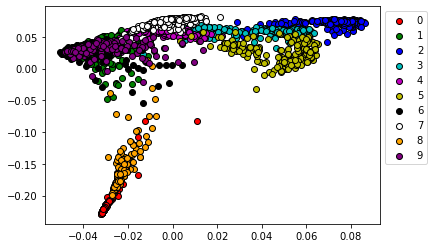

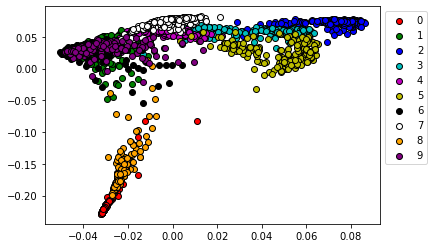

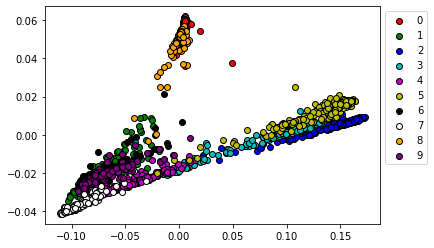

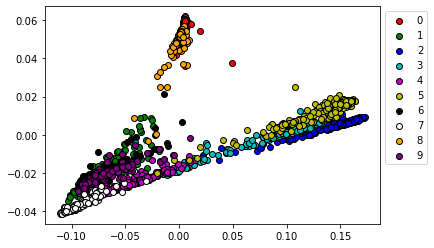

In [15]:
X = []
X1 = np.loadtxt("mfeat-fac")
X.append(X1)
X2 = np.loadtxt("mfeat-fou")
X.append(X2)
X2 = np.loadtxt("mfeat-kar")
X.append(X2)
X2 = np.loadtxt("mfeat-mor")
X.append(X2)
X2 = np.loadtxt("mfeat-pix")
X.append(X2)
X2 = np.loadtxt("mfeat-zer")
X.append(X2)

reds = ['pca','isomap']
for r in reds:
    print("Using mSNE and", r)
    Y = mSNE(X, no_dims = 10, initial_dims = 50, red = r, perplexity = 100, max_iter = 800)
    plot_embedding(Y, true_y)
    raw_best_error_dev, raw_pred = linear_svm(
        Y, true_y, 
        Y, true_y, 
        Y
    )
    plot_embedding(Y, true_y)
    nmi = normalized_mutual_info_score(raw_pred, true_y)
    print("nmi",nmi)
    #ri = rand_score(raw_pred, true_y)
    ari = adjusted_rand_score(raw_pred, true_y)
    #print("RI",ri)
    print("ARI",ari)


Preprocessing the data using PCA...
Computing pairwise distances...
Mean value of sigma: 414.244469
Iteration 400: error is 0.745311
Iteration 800: error is 0.707059
Performing linear SVM!
C = 0.010000, dev error = 0.477000
C = 0.100000, dev error = 0.391500
C = 1.000000, dev error = 0.374000
Selected classifier with best dev error 0.374000
nmi 0.6040339384904055
ARI 0.471614573684927


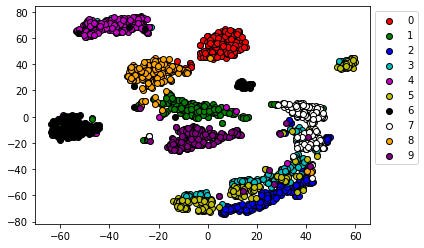

In [17]:
X1 = np.loadtxt("mfeat-fac")

X2 = np.loadtxt("mfeat-fou")

X3 = np.loadtxt("mfeat-kar")

X4 = np.loadtxt("mfeat-mor")

X5 = np.loadtxt("mfeat-pix")

X6 = np.loadtxt("mfeat-zer")


X = np.concatenate((X1, X2,X3,X4,X5,X6), axis=1)
Y = tsne(X)
plot_embedding(Y, true_y)
raw_best_error_dev, raw_pred = linear_svm(
    Y, true_y, 
    Y, true_y, 
    Y
)
nmi = normalized_mutual_info_score(raw_pred, true_y)
print("nmi",nmi)
#ri = rand_score(raw_pred, true_y)
ari = adjusted_rand_score(raw_pred, true_y)
#print("RI",ri)
print("ARI",ari)

Using multi-SNE and pca
Computing pairwise distances...
Mean value of sigma: 356.717172
Computing pairwise distances...
Mean value of sigma: 0.252028
Computing pairwise distances...
Mean value of sigma: 8.499729
Computing pairwise distances...
Mean value of sigma: 252.466661
Computing pairwise distances...
Mean value of sigma: 15.438016
Computing pairwise distances...
Mean value of sigma: 140.219118
Iteration 400: error is 0.956766
Iteration 400: error is 1.360678
Iteration 400: error is 0.759752
Iteration 400: error is 2.452814
Iteration 400: error is 0.721214
Iteration 400: error is 1.083461
Iteration 800: error is 0.953898
Iteration 800: error is 1.357707
Iteration 800: error is 0.755025
Iteration 800: error is 2.454659
Iteration 800: error is 0.716083
Iteration 800: error is 1.079110
Performing linear SVM!
C = 0.010000, dev error = 0.076000
C = 0.100000, dev error = 0.035500
C = 1.000000, dev error = 0.029000
Selected classifier with best dev error 0.029000
nmi 0.9361769926115524
A

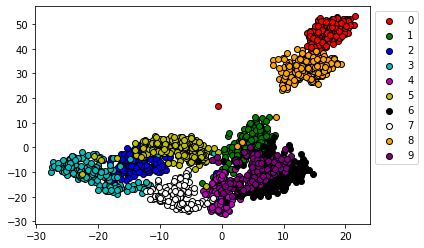

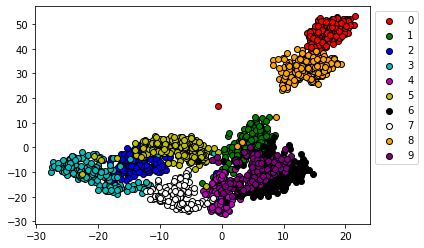

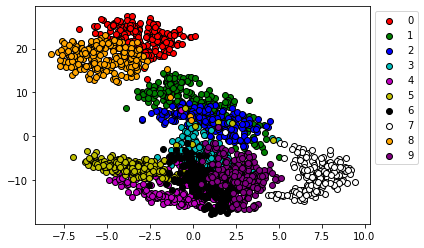

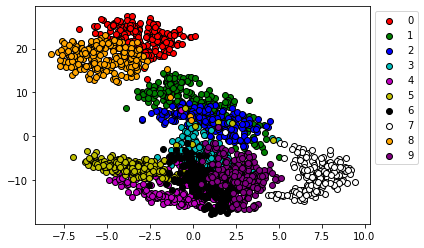

In [5]:
#######################################################
X = []
X1 = np.loadtxt("mfeat-fac")
X.append(X1)
X2 = np.loadtxt("mfeat-fou")
X.append(X2)
X2 = np.loadtxt("mfeat-kar")
X.append(X2)
X2 = np.loadtxt("mfeat-mor")
X.append(X2)
X2 = np.loadtxt("mfeat-pix")
X.append(X2)
X2 = np.loadtxt("mfeat-zer")
X.append(X2)
reds = ['pca','isomap']
for r in reds:
    print("Using multi-SNE and", r)
    Y = multi_SNE(X, no_dims = 10, initial_dims = 50, red = r, perplexity = 100, max_iter = 800)
    plot_embedding(Y, true_y)
    raw_best_error_dev, raw_pred = linear_svm(
        Y, true_y, 
        Y, true_y, 
        Y
    )
    plot_embedding(Y, true_y)
    nmi = normalized_mutual_info_score(raw_pred, true_y)
    print("nmi",nmi)
    #ri = rand_score(raw_pred, true_y)
    ari = adjusted_rand_score(raw_pred, true_y)
    #print("RI",ri)
    print("ARI",ari)

#########################################################

In [ ]:
######################################################################################################################

In [3]:
# Read data for single view handwritten digits
X_val,y_val = read_MNIST("validation")

Using multi-SNE and pca
Computing pairwise distances...
Mean value of sigma: 509.664089
Computing pairwise distances...
Mean value of sigma: 538.426362
Iteration 400: error is 4.759214
Performing linear SVM!
C = 0.010000, dev error = 0.267500
C = 0.100000, dev error = 0.207500
C = 1.000000, dev error = 0.173500
Selected classifier with best dev error 0.173500
nmi 0.742873641699859
RI 0.9427418709354677
ARI 0.6856584977063362
Using multi-SNE and isomap
Computing pairwise distances...
Mean value of sigma: 2360.311917
Computing pairwise distances...
Mean value of sigma: 2561.187371
Iteration 400: error is 4.612897
Performing linear SVM!
C = 0.010000, dev error = 0.248500
C = 0.100000, dev error = 0.201500
C = 1.000000, dev error = 0.167000
Selected classifier with best dev error 0.167000
nmi 0.7507282761599726
RI 0.9449294647323662
ARI 0.6972084958435665


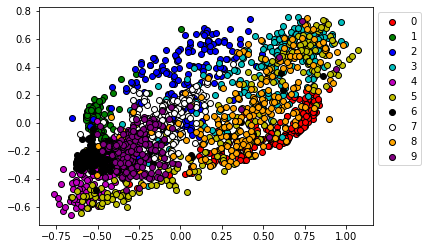

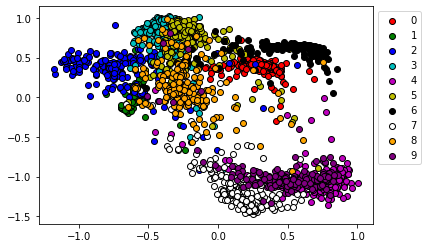

In [6]:
# #################################################################
X=np.hsplit(X_val[::5], 2)
reds = ['pca']
for r in reds:
    print("Using multi-SNE and", r)
    Y = mSNE(X,no_dims = 10, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    plot_embedding(Y, y_val[::5])
    raw_best_error_dev, raw_pred = linear_svm(
        Y, y_val[::5], 
        Y, y_val[::5], 
        Y
    )
    nmi = normalized_mutual_info_score(raw_pred, y_val[::5])
    print("nmi",nmi)
    ri = rand_score(raw_pred, y_val[::5])
    ari = adjusted_rand_score(raw_pred, y_val[::5])
    print("RI",ri)
    print("ARI",ari)
####################################################################
X=np.hsplit(X_val[::5], 2)
reds = ['isomap']
for r in reds:
    print("Using multi-SNE and", r)
    Y = mSNE(X,no_dims = 10, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    plot_embedding(Y, y_val[::5])
    raw_best_error_dev, raw_pred = linear_svm(
        Y, y_val[::5], 
        Y, y_val[::5], 
        Y
    )
    nmi = normalized_mutual_info_score(raw_pred, y_val[::5])
    print("nmi",nmi)
    ri = rand_score(raw_pred, y_val[::5])
    ari = adjusted_rand_score(raw_pred, y_val[::5])
    print("RI",ri)
    print("ARI",ari)


Using multi-SNE and umap
Computing pairwise distances...
Mean value of sigma: 0.736927
Computing pairwise distances...
Mean value of sigma: 0.665407
Iteration 400: error is 4.149209
Performing linear SVM!
C = 0.010000, dev error = 0.316500
C = 0.100000, dev error = 0.261500
C = 1.000000, dev error = 0.237000
Selected classifier with best dev error 0.237000
nmi 0.6562589913587359
RI 0.9242761380690345
ARI 0.5897570668974641


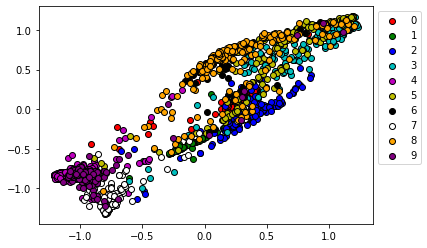

In [5]:
####################################################################
X=np.hsplit(X_val[::5], 2)
reds = ['umap']
for r in reds:
    print("Using multi-SNE and", r)
    Y = mSNE(X,no_dims = 10, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    plot_embedding(Y, y_val[::5])
    raw_best_error_dev, raw_pred = linear_svm(
        Y, y_val[::5], 
        Y, y_val[::5], 
        Y
    )
    nmi = normalized_mutual_info_score(raw_pred, y_val[::5])
    print("nmi",nmi)
    ri = rand_score(raw_pred, y_val[::5])
    ari = adjusted_rand_score(raw_pred, y_val[::5])
    print("RI",ri)
    print("ARI",ari)

Preprocessing the data using PCA...
Computing pairwise distances...
Mean value of sigma: 587.061340
Iteration 400: error is 1.075403
Iteration 800: error is 1.037275
Performing linear SVM!
C = 0.010000, dev error = 0.403500
C = 0.100000, dev error = 0.308500
C = 1.000000, dev error = 0.300000
Selected classifier with best dev error 0.300000
nmi 0.665276526346297
RI 0.9121390695347674
ARI 0.5460341390606785


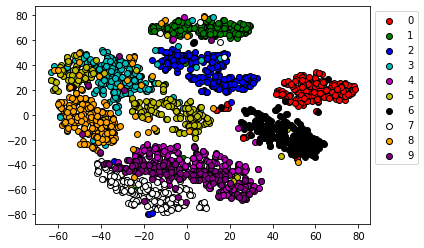

In [9]:
Y = tsne(X_val[::5])
plot_embedding(Y, y_val[::5])
raw_best_error_dev, raw_pred = linear_svm(
    Y, y_val[::5], 
    Y, y_val[::5], 
    Y
)
nmi = normalized_mutual_info_score(raw_pred, y_val[::5])
print("nmi",nmi)
ri = rand_score(raw_pred, y_val[::5])
ari = adjusted_rand_score(raw_pred, y_val[::5])
print("RI",ri)
print("ARI",ari)

Using multi-SNE and pca
Computing pairwise distances...
Mean value of sigma: 509.664089
Computing pairwise distances...
Mean value of sigma: 538.426362
Iteration 400: error is 1.451613
Iteration 400: error is 1.217888
Performing linear SVM!
C = 0.010000, dev error = 0.137500
C = 0.100000, dev error = 0.110500
C = 1.000000, dev error = 0.100000
Selected classifier with best dev error 0.100000
nmi 0.8140907666400342
RI 0.9632461230615308
ARI 0.7960081737613076
Using multi-SNE and isomap
Computing pairwise distances...
Mean value of sigma: 2360.311917
Computing pairwise distances...
Mean value of sigma: 2561.187371
Iteration 400: error is 1.464225
Iteration 400: error is 1.208758
Performing linear SVM!
C = 0.010000, dev error = 0.172000
C = 0.100000, dev error = 0.131000
C = 1.000000, dev error = 0.125000
Selected classifier with best dev error 0.125000
nmi 0.7752879043394867
RI 0.9547903951975988
ARI 0.7497247068869882
Using multi-SNE and umap
Computing pairwise distances...
Mean value o

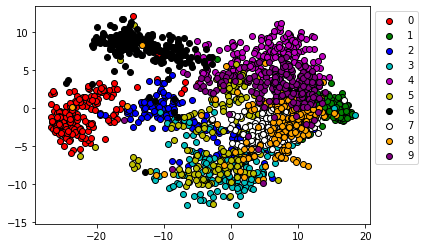

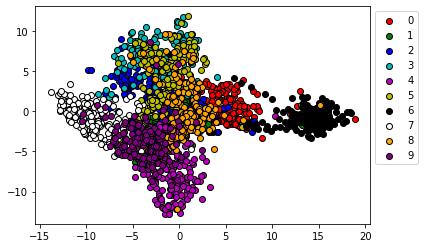

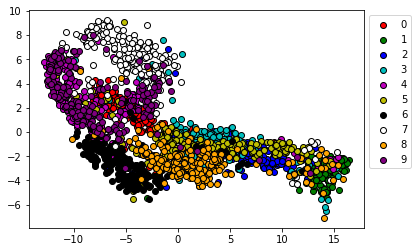

In [8]:
# #################################################################
X=np.hsplit(X_val[::5], 2)
reds = ['pca']
for r in reds:
    print("Using multi-SNE and", r)
    Y = multi_SNE(X,no_dims = 10, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    plot_embedding(Y, y_val[::5])
    raw_best_error_dev, raw_pred = linear_svm(
        Y, y_val[::5], 
        Y, y_val[::5], 
        Y
    )
    nmi = normalized_mutual_info_score(raw_pred, y_val[::5])
    print("nmi",nmi)
    ri = rand_score(raw_pred, y_val[::5])
    ari = adjusted_rand_score(raw_pred, y_val[::5])
    print("RI",ri)
    print("ARI",ari)
####################################################################
X=np.hsplit(X_val[::5], 2)
reds = ['isomap','umap']
for r in reds:
    print("Using multi-SNE and", r)
    Y = multi_SNE(X,no_dims = 10, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    plot_embedding(Y, y_val[::5])
    raw_best_error_dev, raw_pred = linear_svm(
        Y, y_val[::5], 
        Y, y_val[::5], 
        Y
    )
    nmi = normalized_mutual_info_score(raw_pred, y_val[::5])
    print("nmi",nmi)
    ri = rand_score(raw_pred, y_val[::5])
    ari = adjusted_rand_score(raw_pred, y_val[::5])
    print("RI",ri)
    print("ARI",ari)

In [37]:
splits = [2,4,7]
print("mSNE test")
for s in splits:
    print("Split into",s)
    X=np.hsplit(X_val[::5], s)
    Y = mSNE(X,no_dims = 10, initial_dims = 50, red = 'pca', perplexity = 100, max_iter = 300)
    #plot_embedding(Y, y_val[::5])
    raw_best_error_dev, raw_pred = linear_svm(
        Y, y_val[::5], 
        Y, y_val[::5], 
        Y
    )
    nmi = normalized_mutual_info_score(raw_pred, y_val[::5])
    print("nmi",nmi)
    #ri = rand_score(raw_pred, y_val[::5])
    ari = adjusted_rand_score(raw_pred, y_val[::5])
    #print("RI",ri)
    print("ARI",ari)

print("multi_SNE test")    
for s in splits:
    print("Split into",s)
    X=np.hsplit(X_val[::5], s)
    Y = multi_SNE(X,no_dims = 10, initial_dims = 50, red = 'pca', perplexity = 100, max_iter = 300)
    #plot_embedding(Y, y_val[::5])
    raw_best_error_dev, raw_pred = linear_svm(
        Y, y_val[::5], 
        Y, y_val[::5], 
        Y
    )
    nmi = normalized_mutual_info_score(raw_pred, y_val[::5])
    print("nmi",nmi)
    #ri = rand_score(raw_pred, y_val[::5])
    ari = adjusted_rand_score(raw_pred, y_val[::5])
    #print("RI",ri)
    print("ARI",ari)

mSNE test
Split into 2
Computing pairwise distances...
Mean value of sigma: 509.664089
Computing pairwise distances...
Mean value of sigma: 538.426362
Performing linear SVM!
C = 0.010000, dev error = 0.267500
C = 0.100000, dev error = 0.207500
C = 1.000000, dev error = 0.173500
Selected classifier with best dev error 0.173500
nmi 0.742873641699859
ARI 0.6856584977063362
Split into 4
Computing pairwise distances...
Mean value of sigma: 207.465180
Computing pairwise distances...
Mean value of sigma: 447.929099
Computing pairwise distances...
Mean value of sigma: 446.879793
Computing pairwise distances...
Mean value of sigma: 296.189513
Performing linear SVM!
C = 0.010000, dev error = 0.889000
C = 0.100000, dev error = 0.889000
C = 1.000000, dev error = 0.889000
Selected classifier with best dev error 0.889000
nmi 0.0
ARI 0.0
Split into 7
Computing pairwise distances...
Mean value of sigma: 24.413236
Computing pairwise distances...
Mean value of sigma: 282.442391
Computing pairwise distan

In [ ]:
######################################################################################################################

In [4]:
# Read data for caltech7
caltech = mat_contents['X']
caltech = np.transpose(caltech)
X=[]
for i in range(6):
    X.append(caltech[i][0])
true_y = mat_contents['Y'].reshape((-1,))

Using mSNE and pca
Computing pairwise distances...
Mean value of sigma: 21.164557
Computing pairwise distances...
Mean value of sigma: 4.543705
Computing pairwise distances...
Mean value of sigma: 217.071873
Computing pairwise distances...
Mean value of sigma: 1.361264
Computing pairwise distances...
Mean value of sigma: 0.221028
Computing pairwise distances...
Mean value of sigma: 0.393965
Iteration 400: error is 20.561682
Performing linear SVM!
C = 0.010000, dev error = 0.168250
C = 0.100000, dev error = 0.164179
C = 1.000000, dev error = 0.164179
Selected classifier with best dev error 0.164179
NMI 0.602405241881892
ARI 0.6371927939643652


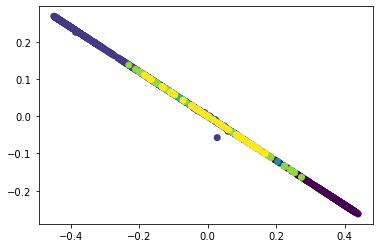

In [5]:
reds = ['pca']
X=[]
for i in range(6):
    X.append(caltech[i][0])
for r in reds:
    print("Using mSNE and", r)
    Y = mSNE(X,no_dims = 2, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    #plot_embedding(Y, true_y)
    raw_best_error_dev, raw_pred = linear_svm(
        Y, true_y, 
        Y, true_y, 
        Y
    )
    fig = plt.figure()
    plt.scatter(Y[:, 0], Y[:, 1], c=true_y)
    nmi = normalized_mutual_info_score(raw_pred, true_y)
    print("NMI",nmi)
    #ri = rand_score(raw_pred, true_y)
    ari = adjusted_rand_score(raw_pred, true_y)
    #print("RI",ri)
    print("ARI",ari)

In [9]:
true_y.shape

(1474,)

Using mSNE and isomap
Computing pairwise distances...
Mean value of sigma: 53.199008
Computing pairwise distances...
Mean value of sigma: 13.423691
Computing pairwise distances...
Mean value of sigma: 688.995413
Computing pairwise distances...
Mean value of sigma: 8.704747
Computing pairwise distances...
Mean value of sigma: 1.018144
Computing pairwise distances...
Mean value of sigma: 2.055042
Iteration 400: error is 20.262394
Performing linear SVM!
C = 0.010000, dev error = 0.164179
C = 0.100000, dev error = 0.163501
C = 1.000000, dev error = 0.163501
Selected classifier with best dev error 0.163501
NMI 0.6091432752903065
ARI 0.6392473427634792


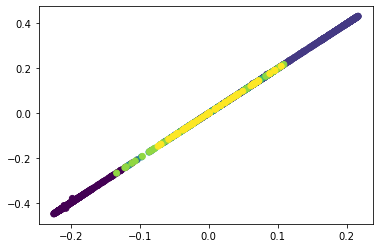

In [24]:
reds = ['isomap']
X=[]
for i in range(6):
    X.append(caltech[i][0])
for r in reds:
    print("Using mSNE and", r)
    Y = mSNE(X,no_dims = 2, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    #plot_embedding(Y, true_y)
    fig = plt.figure()
    plt.scatter(Y[:, 0], Y[:, 1], c=true_y)
    raw_best_error_dev, raw_pred = linear_svm(
        Y, true_y, 
        Y, true_y, 
        Y
    )
    nmi = normalized_mutual_info_score(raw_pred, true_y)
    print("NMI",nmi)
    #ri = rand_score(raw_pred, true_y)
    ari = adjusted_rand_score(raw_pred, true_y)
    #print("RI",ri)
    print("ARI",ari)

Preprocessing the data using PCA...
Computing pairwise distances...
Mean value of sigma: 167.514749
Iteration 400: error is 0.933971
Iteration 800: error is 0.913418
Performing linear SVM!
C = 0.010000, dev error = 0.176391
C = 0.100000, dev error = 0.175712
C = 1.000000, dev error = 0.177069
Selected classifier with best dev error 0.175712
nmi 0.5521079824782884
ARI 0.5943666832623913


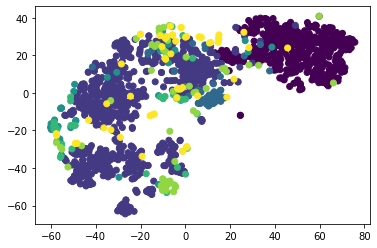

In [25]:
X = np.concatenate((caltech[0][0],caltech[1][0],caltech[2][0],caltech[3][0],caltech[4][0],caltech[5][0]), axis=1)
Y = tsne(X)
#plot_embedding(Y, true_y)
fig = plt.figure()
plt.scatter(Y[:, 0], Y[:, 1], c=true_y)
raw_best_error_dev, raw_pred = linear_svm(
    Y, true_y, 
    Y, true_y, 
    Y
)
nmi = normalized_mutual_info_score(raw_pred, true_y)
print("nmi",nmi)
#ri = rand_score(raw_pred, true_y)
ari = adjusted_rand_score(raw_pred, true_y)
#print("RI",ri)
print("ARI",ari)

Using multi-SNE and pca
Computing pairwise distances...
Mean value of sigma: 21.164557
Computing pairwise distances...
Mean value of sigma: 4.543705
Computing pairwise distances...
Mean value of sigma: 217.071873
Computing pairwise distances...
Mean value of sigma: 1.361264
Computing pairwise distances...
Mean value of sigma: 0.221028
Computing pairwise distances...
Mean value of sigma: 0.393965
Iteration 400: error is 2.154797
Iteration 400: error is 1.542210
Iteration 400: error is 1.365307
Iteration 400: error is 1.093559
Iteration 400: error is 1.182036
Iteration 400: error is 1.067819
Performing linear SVM!
C = 0.010000, dev error = 0.165536
C = 0.100000, dev error = 0.165536
C = 1.000000, dev error = 0.165536
Selected classifier with best dev error 0.165536
NMI 0.5664682311853824
ARI 0.665237751711305
Using multi-SNE and isomap
Computing pairwise distances...
Mean value of sigma: 53.199008
Computing pairwise distances...
Mean value of sigma: 13.423691
Computing pairwise distances

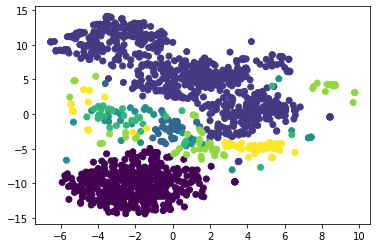

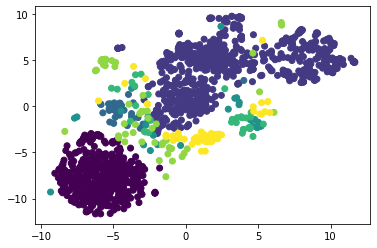

In [22]:
reds = ['pca']
X=[]
for i in range(6):
    X.append(caltech[i][0])
for r in reds:
    print("Using multi-SNE and", r)
    Y = multi_SNE(X,no_dims = 2, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    #plot_embedding(Y, true_y)
    fig = plt.figure()
    plt.scatter(Y[:, 0], Y[:, 1], c=true_y)
    raw_best_error_dev, raw_pred = linear_svm(
        Y, true_y, 
        Y, true_y, 
        Y
    )
    nmi = normalized_mutual_info_score(raw_pred, true_y)
    print("NMI",nmi)
    #ri = rand_score(raw_pred, true_y)
    ari = adjusted_rand_score(raw_pred, true_y)
    #print("RI",ri)
    print("ARI",ari)
######################################################################################################################
reds = ['isomap']
X=[]
for i in range(6):
    X.append(caltech[i][0])
for r in reds:
    print("Using multi-SNE and", r)
    Y = multi_SNE(X,no_dims = 2, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    #plot_embedding(Y, true_y)
    fig = plt.figure()
    plt.scatter(Y[:, 0], Y[:, 1], c=true_y)
    raw_best_error_dev, raw_pred = linear_svm(
        Y, true_y, 
        Y, true_y, 
        Y
    )
    nmi = normalized_mutual_info_score(raw_pred, true_y)
    print("NMI",nmi)
    #ri = rand_score(raw_pred, true_y)
    ari = adjusted_rand_score(raw_pred, true_y)
    #print("RI",ri)
    print("ARI",ari)

In [3]:
######################################################################################################################

In [3]:
# Cancer data read
Breast_Gene = np.loadtxt("./Breast/BREAST_Gene_Expression.txt",skiprows=1,usecols=range(1,106))
Breast_Methy = np.loadtxt("./Breast/BREAST_Methy_Expression.txt",skiprows=1,usecols=range(1,106))
Breast_Mirna = np.loadtxt("./Breast/BREAST_Mirna_Expression.txt",skiprows=1,usecols=range(1,106))
Breast_survive = np.loadtxt("./Breast/BREAST_Survival.txt",skiprows=1,usecols=2)

#Colon_Gene = np.loadtxt("./Colon/Colon_Gene_Expression.txt",skiprows=1,usecols=range(1,93))
#Colon_Methy = np.loadtxt("./Colon/Colon_Methy_Expression.txt",skiprows=1,usecols=range(1,93))
#Colon_Mirna = np.loadtxt("./Colon/Colon_Mirna_Expression.txt",skiprows=1,usecols=range(1,93))
#Colon_survive = np.loadtxt("./Colon/Colon_Survival.txt",skiprows=1,usecols=2)

#GBM_Gene = np.loadtxt("./GBM/GLIO_Gene_Expression.txt",skiprows=1,usecols=range(1,216))
#GBM_Methy = np.loadtxt("./GBM/GLIO_Methy_Expression.txt",skiprows=1,usecols=range(1,216))
#GBM_Mirna = np.loadtxt("./GBM/GLIO_Mirna_Expression.txt",skiprows=1,usecols=range(1,216))
#GBM_survive = np.loadtxt("./GBM/GLIO_Survival.txt",skiprows=1,usecols=2)

Kidney_Gene = np.loadtxt("./Kidney/Kidney_Gene_Expression.txt",skiprows=1,usecols=range(1,123))
Kidney_Methy = np.loadtxt("./Kidney/Kidney_Methy_Expression.txt",skiprows=1,usecols=range(2,124))
Kidney_Mirna = np.loadtxt("./Kidney/Kidney_Mirna_Expression.txt",skiprows=1,usecols=range(1,123))
Kidney_survive = np.loadtxt("./Kidney/Kidney_Survival.txt",skiprows=1,usecols=2)

Lung_Gene = np.loadtxt("./Lung/Lung_Gene_Expression.txt",skiprows=1,usecols=range(1,107))
Lung_Methy = np.loadtxt("./Lung/Lung_Methy_Expression.txt",skiprows=1,usecols=range(1,107))
Lung_Mirna = np.loadtxt("./Lung/Lung_Mirna_Expression.txt",skiprows=1,usecols=range(1,107))
Lung_survive = np.loadtxt("./Lung/Lung_Survival.txt",skiprows=1,usecols=2)

PBreast_Gene = PCA(n_components=80).fit_transform(Breast_Gene.T)
#PColon_Gene = PCA(n_components=80).fit_transform(Colon_Gene.T)
#PGBM_Gene = PCA(n_components=80).fit_transform(GBM_Gene.T)
PKidney_Gene = PCA(n_components=80).fit_transform(Kidney_Gene.T)
PLung_Gene = PCA(n_components=80).fit_transform(Lung_Gene.T)

PBreast_Methy = PCA(n_components=80).fit_transform(Breast_Methy.T)
#PColon_Methy = PCA(n_components=80).fit_transform(Colon_Methy.T)
#PGBM_Methy = PCA(n_components=80).fit_transform(GBM_Methy.T)
PKidney_Methy = PCA(n_components=80).fit_transform(Kidney_Methy.T)
PLung_Methy = PCA(n_components=80).fit_transform(Lung_Methy.T)

PBreast_Mirna = PCA(n_components=80).fit_transform(Breast_Mirna.T)
#PColon_Mirna = PCA(n_components=80).fit_transform(Colon_Mirna.T)
#PGBM_Mirna = PCA(n_components=80).fit_transform(GBM_Mirna.T)
PKidney_Mirna = PCA(n_components=80).fit_transform(Kidney_Mirna.T)
PLung_Mirna = PCA(n_components=80).fit_transform(Lung_Mirna.T)


Gene = np.concatenate(((PBreast_Gene),PKidney_Gene,PLung_Gene), axis=0)
Methy = np.concatenate(((PBreast_Methy),PKidney_Methy,PLung_Methy), axis=0)
Mirna = np.concatenate(((PBreast_Mirna),PKidney_Mirna,PLung_Mirna), axis=0)

true_y = np.concatenate((np.zeros((1,105)), np.ones((1,122)),2*np.ones((1,106))), axis=None)

Using mSNE and pca
Computing pairwise distances...
Mean value of sigma: 53.714961
Computing pairwise distances...
Mean value of sigma: 66.221111
Computing pairwise distances...
Mean value of sigma: 7.595492
Iteration 400: error is 5.326850
Performing linear SVM!
C = 0.010000, dev error = 0.630631
C = 0.100000, dev error = 0.615616
C = 1.000000, dev error = 0.612613
Selected classifier with best dev error 0.612613
NMI 0.013816718841849162
ARI 0.004330711404638074
Using mSNE and isomap
Computing pairwise distances...
Mean value of sigma: 151.468828
Computing pairwise distances...
Mean value of sigma: 178.267919
Computing pairwise distances...
Mean value of sigma: 20.981947
Iteration 400: error is 5.220952
Performing linear SVM!
C = 0.010000, dev error = 0.633634
C = 0.100000, dev error = 0.627628
C = 1.000000, dev error = 0.630631
Selected classifier with best dev error 0.627628
NMI 0.004472813819119007
ARI 0.0007748731096774436


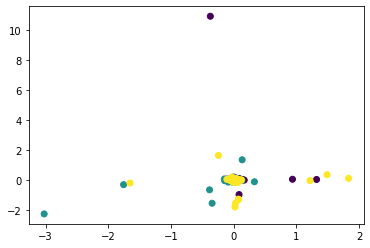

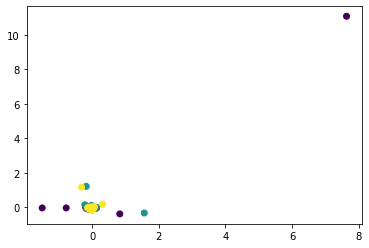

In [28]:
X = []
X.append((Gene))
X.append((Methy))
X.append((Mirna))

reds = ['pca']
for r in reds:
    print("Using mSNE and", r)
    Y = mSNE(X,no_dims = 2, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    #plot_embedding(Y, true_y)
    raw_best_error_dev, raw_pred = linear_svm(
            Y, true_y, 
            Y, true_y, 
            Y
        )
    #raw_pred = KMeans(n_clusters=3, random_state=0).fit_predict(Y)
    fig = plt.figure()
    plt.scatter(Y[:, 0], Y[:, 1], c=true_y)
    nmi = normalized_mutual_info_score(raw_pred, true_y)
    print("NMI",nmi)
    #ri = rand_score(raw_pred, true_y)
    ari = adjusted_rand_score(raw_pred, true_y)
    #print("RI",ri)
    print("ARI",ari)
######################################################################################################################
X = []
X.append((Gene))
X.append((Methy))
X.append((Mirna))

reds = ['isomap']
for r in reds:
    print("Using mSNE and", r)
    Y = mSNE(X,no_dims = 2, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    #plot_embedding(Y, true_y)
    raw_best_error_dev, raw_pred = linear_svm(
            Y, true_y, 
            Y, true_y, 
            Y
        )
    #raw_pred = KMeans(n_clusters=3, random_state=0).fit_predict(Y)
    fig = plt.figure()
    plt.scatter(Y[:, 0], Y[:, 1], c=true_y)
    nmi = normalized_mutual_info_score(raw_pred, true_y)
    print("NMI",nmi)
    #ri = rand_score(raw_pred, true_y)
    ari = adjusted_rand_score(raw_pred, true_y)
    #print("RI",ri)
    print("ARI",ari)

Preprocessing the data using PCA...
Computing pairwise distances...
Mean value of sigma: 58.540805
Iteration 400: error is 1.033862
Iteration 800: error is 1.027009
Performing linear SVM!
C = 0.010000, dev error = 0.618619
C = 0.100000, dev error = 0.609610
C = 1.000000, dev error = 0.606607
Selected classifier with best dev error 0.606607
NMI 0.007191925292105533
ARI 0.006257270158562077


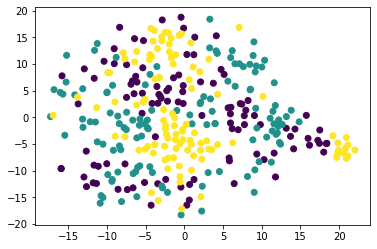

In [29]:
X = np.concatenate((Gene, Methy, Mirna), axis=1)
Y = tsne(X)
#plot_embedding(Y, true_y)
raw_best_error_dev, raw_pred = linear_svm(
        Y, true_y, 
        Y, true_y, 
        Y
    )
#raw_pred = KMeans(n_clusters=3, random_state=0).fit_predict(Y)
fig = plt.figure()
plt.scatter(Y[:, 0], Y[:, 1], c=true_y)
nmi = normalized_mutual_info_score(raw_pred, true_y)
print("NMI",nmi)
#ri = rand_score(raw_pred, true_y)
ari = adjusted_rand_score(raw_pred, true_y)
#print("RI",ri)
print("ARI",ari)

Using multi_SNE and pca
Computing pairwise distances...
Mean value of sigma: 53.752297
Computing pairwise distances...
Mean value of sigma: 66.323365
Computing pairwise distances...
Mean value of sigma: 7.595492
Iteration 400: error is 0.778420
Iteration 400: error is 0.739296
Iteration 400: error is 0.688204
Performing linear SVM!
C = 0.010000, dev error = 0.618619
C = 0.100000, dev error = 0.621622
C = 1.000000, dev error = 0.621622
Selected classifier with best dev error 0.618619
NMI 0.004933719332705778
ARI 0.002269051143082428
Using mSNE and isomap
Computing pairwise distances...
Mean value of sigma: 151.319231
Computing pairwise distances...
Mean value of sigma: 181.752809
Computing pairwise distances...
Mean value of sigma: 20.981947
Iteration 400: error is 1.017579
Iteration 400: error is 0.785350
Iteration 400: error is 0.777485
Performing linear SVM!
C = 0.010000, dev error = 0.558559
C = 0.100000, dev error = 0.549550
C = 1.000000, dev error = 0.546547
Selected classifier wi

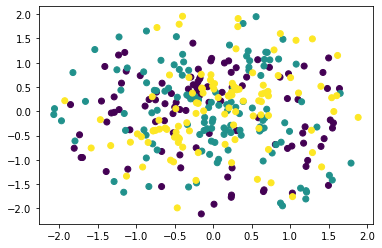

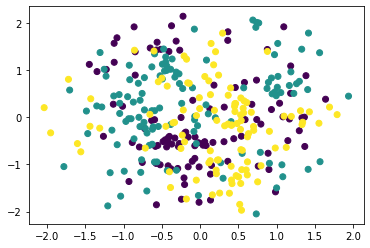

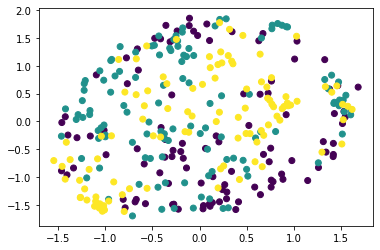

In [5]:
X = []
X.append((Gene))
X.append((Methy))
X.append((Mirna))

reds = ['pca']
for r in reds:
    print("Using multi_SNE and", r)
    Y = multi_SNE(X,no_dims = 2, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    #plot_embedding(Y, true_y)
    raw_best_error_dev, raw_pred = linear_svm(
            Y, true_y, 
            Y, true_y, 
            Y
        )
    #raw_pred = KMeans(n_clusters=3, random_state=0).fit_predict(Y)
    fig = plt.figure()
    plt.scatter(Y[:, 0], Y[:, 1], c=true_y)
    nmi = normalized_mutual_info_score(raw_pred, true_y)
    print("NMI",nmi)
    #ri = rand_score(raw_pred, true_y)
    ari = adjusted_rand_score(raw_pred, true_y)
    #print("RI",ri)
    print("ARI",ari)
######################################################################################################################
X = []
X.append((Gene))
X.append((Methy))
X.append((Mirna))

reds = ['isomap']
for r in reds:
    print("Using mSNE and", r)
    Y = multi_SNE(X,no_dims = 2, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    #plot_embedding(Y, true_y)
    raw_best_error_dev, raw_pred = linear_svm(
            Y, true_y, 
            Y, true_y, 
            Y
        )
    #raw_pred = KMeans(n_clusters=3, random_state=0).fit_predict(Y)
    fig = plt.figure()
    plt.scatter(Y[:, 0], Y[:, 1], c=true_y)
    nmi = normalized_mutual_info_score(raw_pred, true_y)
    print("NMI",nmi)
    #ri = rand_score(raw_pred, true_y)
    ari = adjusted_rand_score(raw_pred, true_y)
    #print("RI",ri)
    print("ARI",ari)
    ######################################################################################################################
X = []
X.append((Gene))
X.append((Methy))
X.append((Mirna))

reds = ['umap']
for r in reds:
    print("Using mSNE and", r)
    Y = multi_SNE(X,no_dims = 2, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    #plot_embedding(Y, true_y)
    raw_best_error_dev, raw_pred = linear_svm(
            Y, true_y, 
            Y, true_y, 
            Y
        )
    #raw_pred = KMeans(n_clusters=3, random_state=0).fit_predict(Y)
    fig = plt.figure()
    plt.scatter(Y[:, 0], Y[:, 1], c=true_y)
    nmi = normalized_mutual_info_score(raw_pred, true_y)
    print("NMI",nmi)
    #ri = rand_score(raw_pred, true_y)
    ari = adjusted_rand_score(raw_pred, true_y)
    #print("RI",ri)
    print("ARI",ari)

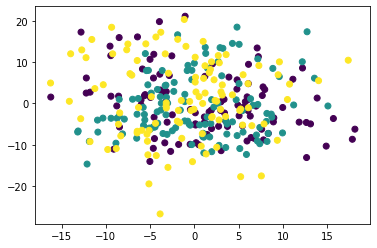

In [48]:
plt.scatter(Y[:, 0], Y[:, 1], c=true_y)

In [ ]:
######################################################################################################################

In [86]:
# Multi-view noisy data
X1 = noisy['tune']
X2 = noisy['tune2']
PX1 = PCA(n_components=100).fit_transform(X1)
PX2 = PCA(n_components=100).fit_transform(X1)
true_y = noisy['tuneLabel'].reshape((-1,))

Using multi_SNE and pca
Computing pairwise distances...
Mean value of sigma: 2.709724
Computing pairwise distances...
Mean value of sigma: 2.709713
Iteration 400: error is 4.778290
Performing linear SVM!
C = 0.010000, dev error = 0.379000
C = 0.100000, dev error = 0.333000
C = 1.000000, dev error = 0.318500
Selected classifier with best dev error 0.318500
NMI 0.6091888408737595
ARI 0.5086725283790376
Using mSNE and isomap
Computing pairwise distances...
Mean value of sigma: 13.017318
Computing pairwise distances...
Mean value of sigma: 13.046624
Iteration 400: error is 4.114844
Performing linear SVM!
C = 0.010000, dev error = 0.356500
C = 0.100000, dev error = 0.334000
C = 1.000000, dev error = 0.332500
Selected classifier with best dev error 0.332500
NMI 0.5812070618065901
ARI 0.47999473774974916


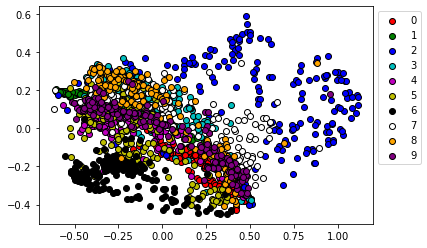

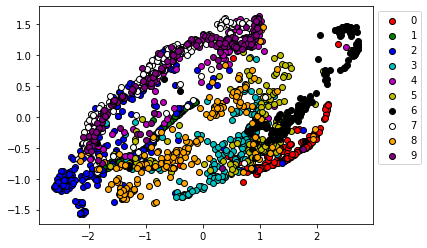

In [88]:
X = []
X.append(PX1[::5])
X.append(PX2[::5])


reds = ['pca']
for r in reds:
    print("Using multi_SNE and", r)
    Y = mSNE(X,no_dims = 10, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    plot_embedding(Y, true_y[::5])
    raw_best_error_dev, raw_pred = linear_svm(
        Y, true_y[::5], 
        Y, true_y[::5], 
        Y
    )
    nmi = normalized_mutual_info_score(raw_pred, true_y[::5])
    print("NMI",nmi)
    #ri = rand_score(raw_pred, true_y[::5])
    ari = adjusted_rand_score(raw_pred, true_y[::5])
    #print("RI",ri)
    print("ARI",ari)
######################################################################################################################
X = []
X.append(PX1[::5])
X.append(PX2[::5])

reds = ['isomap']
for r in reds:
    print("Using mSNE and", r)
    Y = mSNE(X,no_dims = 10, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    plot_embedding(Y, true_y[::5])
    raw_best_error_dev, raw_pred = linear_svm(
        Y, true_y[::5], 
        Y, true_y[::5], 
        Y
    )
    nmi = normalized_mutual_info_score(raw_pred, true_y[::5])
    print("NMI",nmi)
    #ri = rand_score(raw_pred, true_y[::5])
    ari = adjusted_rand_score(raw_pred, true_y[::5])
    #print("RI",ri)
    print("ARI",ari)

Preprocessing the data using PCA...
Computing pairwise distances...
Mean value of sigma: 3.258883
Iteration 400: error is 1.166037
Iteration 800: error is 1.125717
Performing linear SVM!
C = 0.010000, dev error = 0.680000
C = 0.100000, dev error = 0.639500
C = 1.000000, dev error = 0.631000
Selected classifier with best dev error 0.631000
NMI 0.4092370914557697
ARI 0.25756890241131386


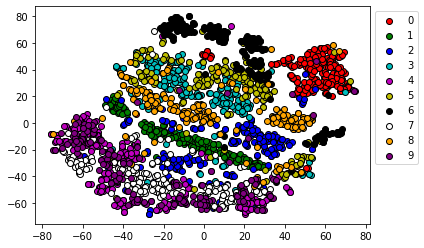

In [90]:
X = np.concatenate((PX1[::5],PX2[::5]), axis=1)
Y = tsne(X)
plot_embedding(Y, true_y[::5])
raw_best_error_dev, raw_pred = linear_svm(
        Y, true_y[::5], 
        Y, true_y[::5], 
        Y
    )
nmi = normalized_mutual_info_score(raw_pred, true_y[::5])
print("NMI",nmi)
#ri = rand_score(raw_pred, true_y[::5])
ari = adjusted_rand_score(raw_pred, true_y[::5])
#print("RI",ri)
print("ARI",ari)

Using multi_SNE and pca
Computing pairwise distances...
Mean value of sigma: 2.709724
Computing pairwise distances...
Mean value of sigma: 2.709713
Iteration 400: error is 0.790179
Iteration 400: error is 0.790241
Performing linear SVM!
C = 0.010000, dev error = 0.231500
C = 0.100000, dev error = 0.215000
C = 1.000000, dev error = 0.206500
Selected classifier with best dev error 0.206500
NMI 0.6899329538524236
ARI 0.6348653670871901
Using mSNE and isomap
Computing pairwise distances...
Mean value of sigma: 13.017318
Computing pairwise distances...
Mean value of sigma: 13.046624
Iteration 400: error is 0.620887
Iteration 400: error is 0.619016
Performing linear SVM!
C = 0.010000, dev error = 0.290000
C = 0.100000, dev error = 0.267500
C = 1.000000, dev error = 0.268000
Selected classifier with best dev error 0.267500
NMI 0.6207145081052011
ARI 0.5431272125647024


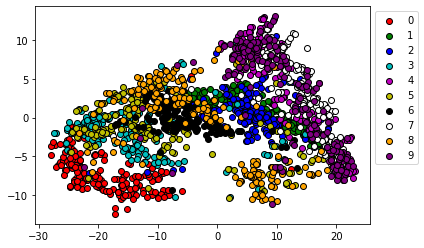

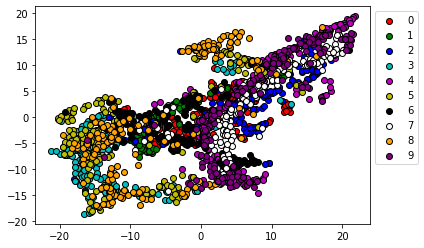

In [91]:
X = []
X.append(PX1[::5])
X.append(PX2[::5])


reds = ['pca']
for r in reds:
    print("Using multi_SNE and", r)
    Y = multi_SNE(X,no_dims = 10, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    plot_embedding(Y, true_y[::5])
    raw_best_error_dev, raw_pred = linear_svm(
        Y, true_y[::5], 
        Y, true_y[::5], 
        Y
    )
    nmi = normalized_mutual_info_score(raw_pred, true_y[::5])
    print("NMI",nmi)
    #ri = rand_score(raw_pred, true_y[::5])
    ari = adjusted_rand_score(raw_pred, true_y[::5])
    #print("RI",ri)
    print("ARI",ari)
######################################################################################################################
X = []
X.append(PX1[::5])
X.append(PX2[::5])

reds = ['isomap']
for r in reds:
    print("Using mSNE and", r)
    Y = multi_SNE(X,no_dims = 10, initial_dims = 50, red = r, perplexity = 100, max_iter = 400)
    plot_embedding(Y, true_y[::5])
    raw_best_error_dev, raw_pred = linear_svm(
        Y, true_y[::5], 
        Y, true_y[::5], 
        Y
    )
    nmi = normalized_mutual_info_score(raw_pred, true_y[::5])
    print("NMI",nmi)
    #ri = rand_score(raw_pred, true_y[::5])
    ari = adjusted_rand_score(raw_pred, true_y[::5])
    #print("RI",ri)
    print("ARI",ari)

In [83]:
PX2.shape


(10000, 100)